# Seleção de atributos

- Análise dos atributos escolhidos utilizando Random Forests.

In [1]:
import pandas as pd 
import numpy as np 
from regression_utils import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [2]:
NORMALIZE = False
ESTIMATORS = 1000

In [3]:
summary_df = pd.DataFrame({"paredoes_decisivos": [0]*len(COLUMNS), "importancia_acumulada": [0]*len(COLUMNS)}, index=COLUMNS, columns=["paredoes_decisivos", "importancia_acumulada"])
summary_df.drop(index=["paredao", "nome", "rejeicao"], inplace=True)

# Paredao 1

In [4]:
train_df, test_df = get_train_test(1, normalize=NORMALIZE)

In [5]:
test_df

,paredao,nome,positivos,neutros,negativos,positivos_individual_pct,neutros_individual_pct,negativos_individual_pct,positivos_global_pct,neutros_global_pct,negativos_global_pct,day1,day2,day3,likes,retweets,seguidores,rejeicao
24,1,bianca_andrade,5102,5230,3762,0.361998,0.37108,0.266922,0.483052,0.326345,0.20701,5849,5903,2342,407879,57730,411880,0.2446
25,1,lucas_chumbo,5460,10796,14411,0.178042,0.35204,0.469919,0.516948,0.673655,0.79299,22759,5502,2406,667691,132858,12014,0.7594


In [6]:
x_train, y_train = train_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), train_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()
x_test, y_test = test_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), test_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()

In [7]:
regressor = SelectFromModel(RandomForestRegressor(n_estimators=ESTIMATORS))

In [8]:
_ = regressor.fit(x_train, y_train)

In [9]:
features = regressor.get_support()
columns = train_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
indexes = columns[features]
features_importance = regressor.estimator_.feature_importances_
indexes

Index(['positivos_individual_pct', 'neutros_individual_pct',
       'neutros_global_pct', 'day1', 'seguidores'],
      dtype='object')

In [10]:
indexes

Index(['positivos_individual_pct', 'neutros_individual_pct',
       'neutros_global_pct', 'day1', 'seguidores'],
      dtype='object')

In [11]:
summary_df["paredoes_decisivos"].loc[indexes] += 1
summary_df["importancia_acumulada"] += features_importance

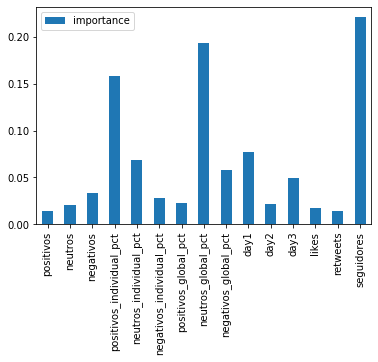

In [12]:
pd.DataFrame(features_importance, index=columns, columns=["importance"]).plot.bar()

# Paredao 2

In [13]:
train_df, test_df = get_train_test(2, normalize=NORMALIZE)
test_df


,paredao,nome,positivos,neutros,negativos,positivos_individual_pct,neutros_individual_pct,negativos_individual_pct,positivos_global_pct,neutros_global_pct,negativos_global_pct,day1,day2,day3,likes,retweets,seguidores,rejeicao
20,2,babu,3819,5049,3822,0.300946,0.397872,0.301182,0.067775,0.054604,0.028657,5606,6016,1068,313738,57539,325345,0.0044
21,2,petrix,17850,41331,62584,0.146594,0.339433,0.513974,0.316781,0.446991,0.469254,46679,64815,10271,3036821,776919,22414,0.8027
22,2,pyong,19947,15248,12907,0.414681,0.316993,0.268326,0.353997,0.164906,0.096777,12527,28745,6830,1889184,357422,1431039,0.0066
23,2,hadson,14732,30837,54056,0.147875,0.309531,0.542595,0.261447,0.333499,0.405312,25263,68537,5825,2416937,583604,10207,0.1863


In [14]:
x_train, y_train = train_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), train_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()
x_test, y_test = test_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), test_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()

In [15]:
regressor = SelectFromModel(RandomForestRegressor(n_estimators=ESTIMATORS))

In [16]:
_ = regressor.fit(x_train, y_train)


In [17]:
features = regressor.get_support()
columns = train_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
indexes = columns[features]
features_importance = regressor.estimator_.feature_importances_
indexes

Index(['positivos_individual_pct', 'neutros_individual_pct',
       'neutros_global_pct', 'seguidores'],
      dtype='object')

In [18]:
summary_df["paredoes_decisivos"].loc[indexes] += 1
summary_df["importancia_acumulada"] += features_importance

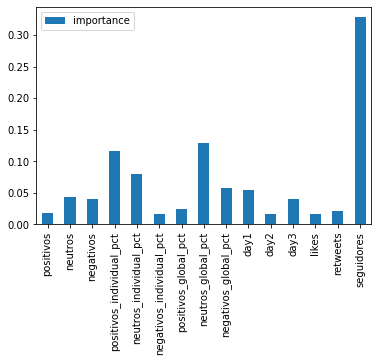

In [19]:
pd.DataFrame(features_importance, index=columns, columns=["importance"]).plot.bar()

# Paredao 3

In [20]:
train_df, test_df = get_train_test(3, normalize=NORMALIZE)
test_df


,paredao,nome,positivos,neutros,negativos,positivos_individual_pct,neutros_individual_pct,negativos_individual_pct,positivos_global_pct,neutros_global_pct,negativos_global_pct,day1,day2,day3,likes,retweets,seguidores,rejeicao
9,3,felipe_prior,2824,3707,3514,0.281135,0.369039,0.349826,0.54644,0.429299,0.468471,1138,6469,2438,434766,81439,204031,0.2029
10,3,hadson,2344,4928,3987,0.208189,0.437694,0.354117,0.45356,0.570701,0.531529,1903,6534,2822,224448,41345,10207,0.7971


In [21]:
x_train, y_train = train_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), train_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()
x_test, y_test = test_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), test_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()

In [22]:
regressor = SelectFromModel(RandomForestRegressor(n_estimators=ESTIMATORS))

In [23]:
_ = regressor.fit(x_train, y_train)

In [24]:
features = regressor.get_support()
columns = train_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
indexes = columns[features]
features_importance = regressor.estimator_.feature_importances_
indexes

Index(['positivos_individual_pct', 'neutros_individual_pct',
       'neutros_global_pct', 'negativos_global_pct', 'day1', 'seguidores'],
      dtype='object')

In [25]:
summary_df["paredoes_decisivos"].loc[indexes] += 1
summary_df["importancia_acumulada"] += features_importance

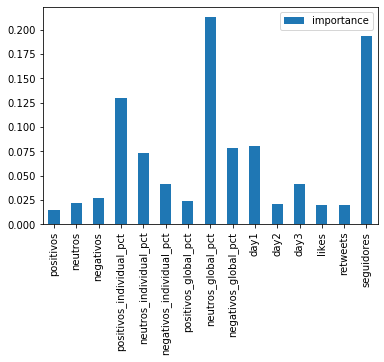

In [26]:
pd.DataFrame(features_importance, index=columns, columns=["importance"]).plot.bar()

# Paredao 4

In [27]:
train_df, test_df = get_train_test(4, normalize=NORMALIZE)
test_df


,paredao,nome,positivos,neutros,negativos,positivos_individual_pct,neutros_individual_pct,negativos_individual_pct,positivos_global_pct,neutros_global_pct,negativos_global_pct,day1,day2,day3,likes,retweets,seguidores,rejeicao
26,4,babu,6766,10814,18799,0.185986,0.297259,0.516754,0.311138,0.324375,0.339940,18271,15505,2603,614605,87114,325345,0.0130
27,4,victor_hugo,2807,4560,4979,0.227361,0.369350,0.403289,0.129081,0.136781,0.090035,6845,4229,1272,259802,43392,14399,0.3608
28,4,lucas,12173,17964,31523,0.197421,0.291340,0.511239,0.559781,0.538845,0.570026,32223,22154,7283,1337004,250861,23670,0.6262


In [28]:
x_train, y_train = train_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), train_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()
x_test, y_test = test_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), test_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()

In [29]:
regressor = SelectFromModel(RandomForestRegressor(n_estimators=ESTIMATORS))

In [30]:
_ = regressor.fit(x_train, y_train)


In [31]:
features = regressor.get_support()
columns = train_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
indexes = columns[features]
features_importance = regressor.estimator_.feature_importances_
indexes

Index(['positivos_individual_pct', 'neutros_individual_pct',
       'neutros_global_pct', 'negativos_global_pct', 'seguidores'],
      dtype='object')

In [32]:
summary_df["paredoes_decisivos"].loc[indexes] += 1
summary_df["importancia_acumulada"] += features_importance

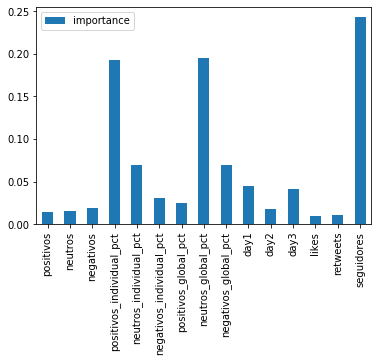

In [33]:
pd.DataFrame(features_importance, index=columns, columns=["importance"]).plot.bar()

# Paredao 5

In [34]:
train_df, test_df = get_train_test(5, normalize=NORMALIZE)
test_df


,paredao,nome,positivos,neutros,negativos,positivos_individual_pct,neutros_individual_pct,negativos_individual_pct,positivos_global_pct,neutros_global_pct,negativos_global_pct,day1,day2,day3,likes,retweets,seguidores,rejeicao
3,5,bianca_andrade,4239,8067,6802,0.221844,0.422179,0.355977,0.370866,0.371940,0.211900,1998,10238,6872,136880,18673,411880,0.5309
4,5,flayslene,2304,4170,6222,0.181474,0.328450,0.490076,0.201575,0.192263,0.193832,1935,7920,2841,244036,42579,104138,0.1764
5,5,felipe_prior,4887,9452,19076,0.146252,0.282867,0.570881,0.427559,0.435797,0.594268,3101,21636,8678,703621,137701,204031,0.2927


In [35]:
x_train, y_train = train_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), train_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()
x_test, y_test = test_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), test_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()

In [36]:
regressor = SelectFromModel(RandomForestRegressor(n_estimators=ESTIMATORS))

In [37]:
_ = regressor.fit(x_train, y_train)


In [38]:
features = regressor.get_support()
columns = train_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
indexes = columns[features]
features_importance = regressor.estimator_.feature_importances_
indexes

Index(['positivos_individual_pct', 'neutros_global_pct',
       'negativos_global_pct', 'seguidores'],
      dtype='object')

In [39]:
summary_df["paredoes_decisivos"].loc[indexes] += 1
summary_df["importancia_acumulada"] += features_importance

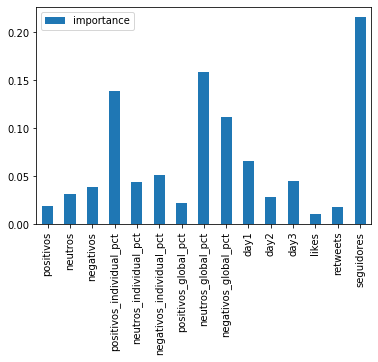

In [40]:
pd.DataFrame(features_importance, index=columns, columns=["importance"]).plot.bar()

# Paredao 6

In [41]:
train_df, test_df = get_train_test(6, normalize=NORMALIZE)
test_df


,paredao,nome,positivos,neutros,negativos,positivos_individual_pct,neutros_individual_pct,negativos_individual_pct,positivos_global_pct,neutros_global_pct,negativos_global_pct,day1,day2,day3,likes,retweets,seguidores,rejeicao
0,6,gizelly_bicalho,20697,18318,14428,0.387272,0.342758,0.269970,0.342739,0.242732,0.106771,20904,23543,8996,2513041,427327,234977,0.0064
1,6,guilherme,15623,26030,61087,0.152063,0.253358,0.594579,0.258715,0.344924,0.452061,49438,35276,18026,2623616,513321,103421,0.5607
2,6,pyong,24067,31118,59615,0.209643,0.271063,0.519294,0.398546,0.412345,0.441168,38968,53242,22590,2790406,500118,1431039,0.4329


In [42]:
x_train, y_train = train_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), train_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()
x_test, y_test = test_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), test_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()

In [43]:
regressor = SelectFromModel(RandomForestRegressor(n_estimators=ESTIMATORS))

In [44]:
_ = regressor.fit(x_train, y_train)


In [45]:
features = regressor.get_support()
columns = train_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
indexes = columns[features]
features_importance = regressor.estimator_.feature_importances_
indexes

Index(['positivos_individual_pct', 'neutros_individual_pct',
       'neutros_global_pct', 'seguidores'],
      dtype='object')

In [46]:
summary_df["paredoes_decisivos"].loc[indexes] += 1
summary_df["importancia_acumulada"] += features_importance

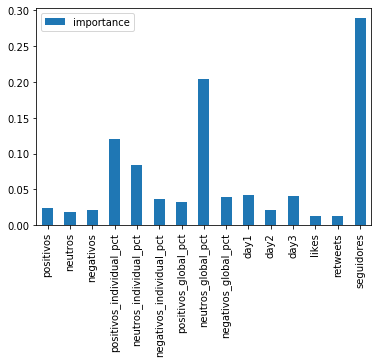

In [47]:
pd.DataFrame(features_importance, index=columns, columns=["importance"]).plot.bar()

# Paredao 7

In [48]:
train_df, test_df = get_train_test(7, normalize=NORMALIZE)
test_df


,paredao,nome,positivos,neutros,negativos,positivos_individual_pct,neutros_individual_pct,negativos_individual_pct,positivos_global_pct,neutros_global_pct,negativos_global_pct,day1,day2,day3,likes,retweets,seguidores,rejeicao
6,7,babu,14706,13814,17650,0.318519,0.299199,0.382283,0.456325,0.382861,0.434205,19044,20262,6864,3245989,421069,325345,0.0460
7,7,manu_gavassi,11741,12131,10756,0.339061,0.350323,0.310616,0.364322,0.336216,0.264607,13372,15830,5426,1347551,161381,4327060,0.1018
8,7,victor_hugo,5780,10136,12243,0.205263,0.359956,0.434781,0.179353,0.280923,0.301188,14217,9331,4611,1370088,192649,14399,0.8522


In [49]:
x_train, y_train = train_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), train_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()
x_test, y_test = test_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), test_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()

In [50]:
regressor = SelectFromModel(RandomForestRegressor(n_estimators=ESTIMATORS))

In [51]:
_ = regressor.fit(x_train, y_train)

In [52]:
features = regressor.get_support()
columns = train_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
indexes = columns[features]
features_importance = regressor.estimator_.feature_importances_
indexes

Index(['neutros_global_pct', 'seguidores'], dtype='object')

In [53]:
summary_df["paredoes_decisivos"].loc[indexes] += 1
summary_df["importancia_acumulada"] += features_importance

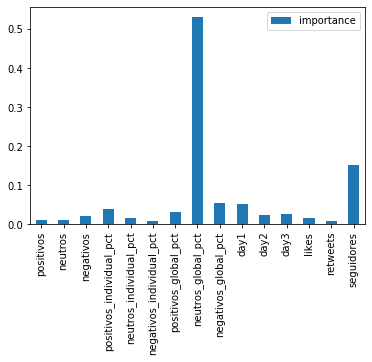

In [54]:
pd.DataFrame(features_importance, index=columns, columns=["importance"]).plot.bar()

# Paredao 8

In [55]:
train_df, test_df = get_train_test(8, normalize=NORMALIZE)
test_df


,paredao,nome,positivos,neutros,negativos,positivos_individual_pct,neutros_individual_pct,negativos_individual_pct,positivos_global_pct,neutros_global_pct,negativos_global_pct,day1,day2,day3,likes,retweets,seguidores,rejeicao
17,8,babu,20043,24848,39041,0.238800,0.296049,0.465150,0.366229,0.314337,0.319854,29102,36583,18247,2746925,442326,325345,0.4771
18,8,rafa,11365,16307,33927,0.184500,0.264728,0.550772,0.207663,0.206290,0.277956,27062,22837,11700,833006,65329,293473,0.0059
19,8,pyong,23320,37894,49091,0.211414,0.343538,0.445048,0.426107,0.479374,0.402191,42474,46841,20990,1884395,331018,1431039,0.5170


In [56]:
x_train, y_train = train_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), train_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()
x_test, y_test = test_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), test_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()

In [57]:
regressor = SelectFromModel(RandomForestRegressor(n_estimators=ESTIMATORS))

In [58]:
_ = regressor.fit(x_train, y_train)
features = regressor.get_support()
columns = train_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
indexes = columns[features]
features_importance = regressor.estimator_.feature_importances_
indexes



Index(['positivos_individual_pct', 'neutros_individual_pct',
       'neutros_global_pct', 'seguidores'],
      dtype='object')

In [59]:
summary_df["paredoes_decisivos"].loc[indexes] += 1
summary_df["importancia_acumulada"] += features_importance

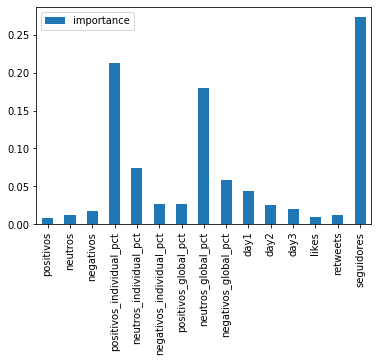

In [60]:
pd.DataFrame(features_importance, index=columns, columns=["importance"]).plot.bar()

# Paredão 9

In [61]:
train_df, test_df = get_train_test(9, normalize=NORMALIZE)
test_df

,paredao,nome,positivos,neutros,negativos,positivos_individual_pct,neutros_individual_pct,negativos_individual_pct,positivos_global_pct,neutros_global_pct,negativos_global_pct,day1,day2,day3,likes,retweets,seguidores,rejeicao
14,9,daniel,17050,28476,35449,0.210559,0.351664,0.437777,0.355075,0.417310,0.397548,43662,24967,12346,2362234,451548,33876,0.8082
15,9,flayslene,18049,20419,29529,0.265438,0.300293,0.434269,0.375880,0.299236,0.331158,14010,41155,12832,2048527,340506,104138,0.0954
16,9,ivy,12919,19342,24191,0.228849,0.342627,0.428523,0.269045,0.283453,0.271294,34835,16734,4883,1801001,319531,59125,0.0964


In [62]:
x_train, y_train = train_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), train_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()
x_test, y_test = test_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), test_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()

In [63]:
regressor = SelectFromModel(RandomForestRegressor(n_estimators=ESTIMATORS))

In [64]:
_ = regressor.fit(x_train, y_train)
features = regressor.get_support()
columns = train_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
indexes = columns[features]
features_importance = regressor.estimator_.feature_importances_
indexes



Index(['positivos_individual_pct', 'neutros_global_pct',
       'negativos_global_pct', 'day1', 'seguidores'],
      dtype='object')

In [65]:
summary_df["paredoes_decisivos"].loc[indexes] += 1
summary_df["importancia_acumulada"] += features_importance

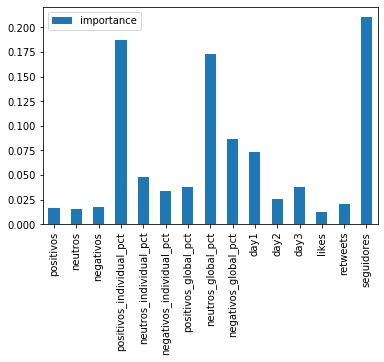

In [66]:
pd.DataFrame(features_importance, index=columns, columns=["importance"]).plot.bar()

# Paredão 10

In [67]:
train_df, test_df = get_train_test(10, normalize=NORMALIZE)
test_df

,paredao,nome,positivos,neutros,negativos,positivos_individual_pct,neutros_individual_pct,negativos_individual_pct,positivos_global_pct,neutros_global_pct,negativos_global_pct,day1,day2,day3,likes,retweets,seguidores,rejeicao
11,10,manu_gavassi,71199,136446,96911,0.233780,0.448016,0.318204,0.559785,0.551039,0.428851,42943,170635,90978,6621309,989025,4785334,0.4251
12,10,mari,19342,23829,25292,0.282518,0.348057,0.369426,0.152072,0.096234,0.111922,19694,32725,16044,967975,131232,269733,0.0076
13,10,felipe_prior,36649,87341,103775,0.160907,0.383470,0.455623,0.288144,0.352728,0.459226,57998,114917,54850,6664432,1291988,642881,0.5673


In [68]:
x_train, y_train = train_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), train_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()
x_test, y_test = test_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), test_df.drop(columns=train_df.columns[:-1], axis=1).to_numpy()

In [69]:
regressor = SelectFromModel(RandomForestRegressor(n_estimators=ESTIMATORS))

In [70]:
_ = regressor.fit(x_train, y_train)
features = regressor.get_support()
columns = train_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
indexes = columns[features]
features_importance = regressor.estimator_.feature_importances_
indexes



Index(['positivos_individual_pct', 'neutros_global_pct', 'seguidores'], dtype='object')

In [71]:
summary_df["paredoes_decisivos"].loc[indexes] += 1
summary_df["importancia_acumulada"] += features_importance

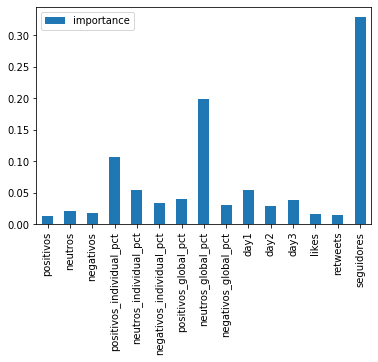

In [72]:
pd.DataFrame(features_importance, index=columns, columns=["importance"]).plot.bar()

# Sumarizando

In [73]:
summary_df.sort_values(by="importancia_acumulada", ascending=False)

,paredoes_decisivos,importancia_acumulada
seguidores,10,2.453565
neutros_global_pct,10,2.174933
positivos_individual_pct,9,1.401885
negativos_global_pct,4,0.645931
neutros_individual_pct,6,0.612011
day1,3,0.589003
day3,0,0.379439
negativos_individual_pct,0,0.309911
positivos_global_pct,0,0.286940
negativos,0,0.254067


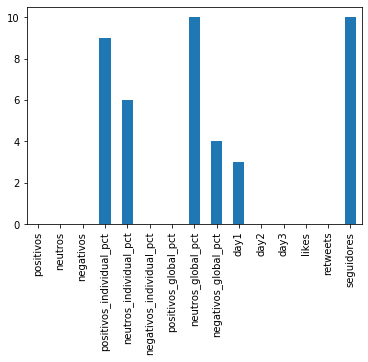

In [74]:
summary_df["paredoes_decisivos"].plot.bar()

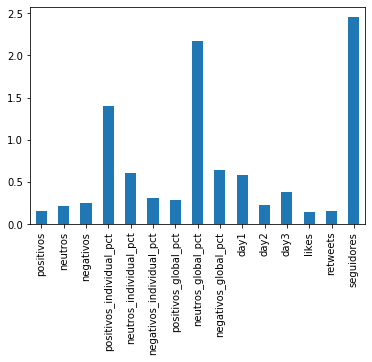

In [75]:
summary_df["importancia_acumulada"].plot.bar()


# Análise de correlação

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,10))

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [77]:
data_df = train_df.append(test_df, ignore_index=True)

In [78]:
cor = data_df.corr()

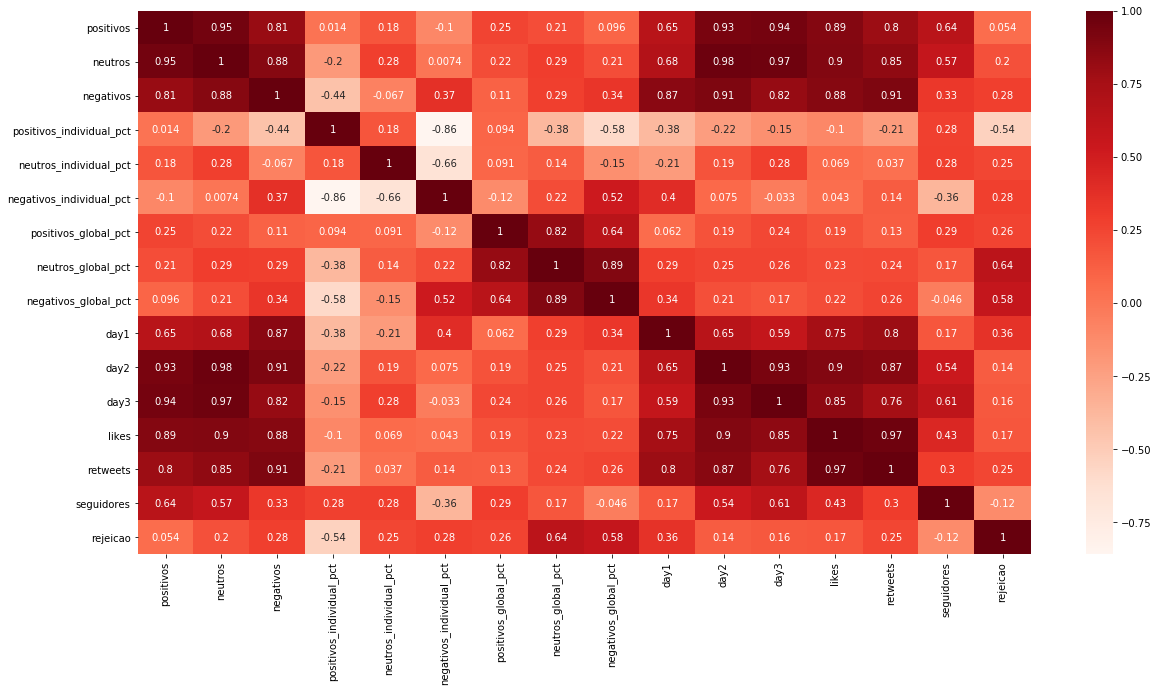

In [79]:
plt.figure(figsize=(20,10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

- Ordenando por correlação

In [80]:
cor_target = abs(cor["rejeicao"])

In [81]:
cor_target.sort_values(ascending=False)

rejeicao                    1.000000
neutros_global_pct          0.636691
negativos_global_pct        0.578259
positivos_individual_pct    0.537587
day1                        0.360902
negativos                   0.284981
negativos_individual_pct    0.283713
positivos_global_pct        0.259496
neutros_individual_pct      0.248517
retweets                    0.247776
neutros                     0.200337
likes                       0.166462
day3                        0.157718
day2                        0.139515
seguidores                  0.123201
positivos                   0.054146
Name: rejeicao, dtype: float64

- Filtrando por correlação superior a 0.5

In [82]:
relevant_features = cor_target[cor_target > 0.5]

In [83]:
relevant_features

positivos_individual_pct    0.537587
neutros_global_pct          0.636691
negativos_global_pct        0.578259
rejeicao                    1.000000
Name: rejeicao, dtype: float64

- Correlação ao atributo alvo (rejeicao) de todos os atributos

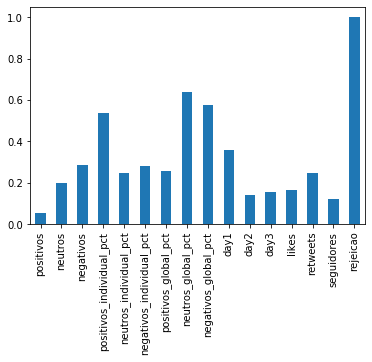

In [84]:
cor_target.plot.bar()